# 对话式RAG

### Chains

In [43]:
import os
from langchain_openai import ChatOpenAI
API_SECRET_KEY = ""
BASE_URL = ""  # 代理 base-url 记得加上 /v1

os.environ["OPENAI_API_KEY"] = API_SECRET_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL
llm = ChatOpenAI()

让我们首先重温一下我们在 RAG 教程中由 Lilian Weng 撰写的 LLM Powered Autonomous Agents 博客文章上构建的 Q&A 应用程序。

In [44]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import FAISS 
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()


EMBEDDING_DEVICE = "cuda"
embeddings=HuggingFaceEmbeddings(model_name= "../models/m3e-base",
                                    model_kwargs={"device":EMBEDDING_DEVICE}
                                )
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)
retriever = vectorstore.as_retriever()


# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "  # 你是一个用于回答问题的助手。
    "Use the following pieces of retrieved context to answer "  # 使用以下检索到的上下文信息来回答问题。
    "the question. If you don't know the answer, say that you "  # 如果你不知道答案，就说你不知道。
    "don't know. Use three sentences maximum and keep the "  # 答案最多使用三句话，并保持简洁。
    "answer concise."
    "\n\n"
    "{context}"  # 这个部分是一个占位符，表示实际操作时会插入检索到的上下文信息。
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt) 
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [45]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

"Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. It is often facilitated by techniques like Chain of Thought (CoT), which instructs models to think step-by-step, or Tree of Thoughts, which explores multiple reasoning possibilities at each step to create a tree structure of thoughts. This approach helps in interpreting the model's thinking process and enhances performance on complex tasks."

### Adding chat history

我们构建的链条直接使用输入查询来检索相关的上下文。但在对话场景中，用户的查询可能需要对话上下文来理解。例如，考虑以下对话：

> 人类：“什么是任务分解？”
> AI：“任务分解是将复杂任务分解为更小、更简单的步骤，以便于代理或模型更好地管理。”
> 人类：“常见的方法有哪些？”

为了回答第二个问题，我们的系统需要理解“它”是指“任务分解”。

我们需要更新现有应用程序的两个方面：

1. Prompt：更新我们的提示，使其支持历史消息作为输入。
2. Contextualizing questions：添加一个子链条，该子链条将最新的用户问题重新表述为包含对话历史上下文的问题。可以简单地认为这是构建一个新的“历史感知”检索器。之前我们是：
`query` -> `retriever`
现在我们是：
`（query，conversation history）` -> `LLM` -> `rephased query` -> `retriever`

**Contextualizing questions**

首先，我们需要定义一个子链条，该子链条将历史消息和最新的用户问题结合起来，如果最新问题引用了历史信息，则重新表述该问题。

我们将使用一个包含名为“chat_history”变量的提示。这使我们能够使用“chat_history”输入键将消息列表传递给提示，这些消息将插入系统消息之后、人类消息（包含最新问题）之前。

注意，我们在此步骤中利用了一个辅助函数 create_history_aware_retriever，该函数处理 chat_history 为空的情况，并按顺序应用 `prompt | llm | StrOutputParser() | retriever`。

create_history_aware_retriever 构建了一个链条，该链条接受 input 和 chat_history 作为输入，并具有与检索器相同的输出模式。

In [46]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "  # 假设有一个对话历史和用户的最新问题
    "which might reference context in the chat history, "  # 最新问题可能引用了对话历史中的上下文
    "formulate a standalone question which can be understood "  # 重新表述一个可以独立理解的问题
    "without the chat history. Do NOT answer the question, "  # 无需回答问题
    "just reformulate it if needed and otherwise return it as is." # 如果需要的话，只需重新表述问题；否则就原样返回问题
)

contextualize_q_prompt = ChatPromptTemplate.from_messages( # 重新表述用户问题，使其包含对话上下文
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever( # 是一个处理了上下文感知的检索器，先重新表述问题再进行检索
    llm, retriever, contextualize_q_prompt
)

这条链会将重新表述后的输入查询添加到我们的检索器之前，以便检索时能包含对话的上下文。

现在我们可以构建完整的问答链了。只需将检索器更新为新的 `history_aware_retriever`。

我们将再次使用 `create_stuff_documents_chain` 来生成一个 `question_answer_chain`，它接受键为 `context`、`chat_history` 和 `input` 的输入 —— 它会将检索到的上下文、对话历史和查询结合起来生成答案。更详细的解释可以在这里找到。

我们使用 `create_retrieval_chain` 构建最终的 rag_chain。这条链按顺序应用 `history_aware_retriever`和 `question_answer_chain`，并保留中间输出（例如检索到的上下文），以便使用。它接受 `input` 和 `chat_history` 作为输入键，并在输出中包含 `input`、`chat_history`、`context` 和 `answer`。

In [47]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages( # 专注于结合上下文和对话历史生成回答
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt) # 负责整个从查询到回答的流程

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain) # 一个完整的回答链条

In [48]:
'''
### `contextualize_q_prompt` 和 `qa_prompt` 的区别与联系

#### `contextualize_q_prompt`

- **作用**：`contextualize_q_prompt` 的主要作用是重新表述用户的问题，使其在不依赖对话历史的情况下也能被理解。这对于处理引用了之前对话内容的问题非常重要。
- **组成**：
  - **系统消息**：`contextualize_q_system_prompt`，指示模型如何处理输入，特别是重新表述问题。
  - **消息占位符**：`MessagesPlaceholder("chat_history")`，用于插入对话历史。
  - **用户消息**：`("{input}")`，表示用户的最新问题。
  
  ```python
  contextualize_q_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", contextualize_q_system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ]
  )
  ```

#### `qa_prompt`

- **作用**：`qa_prompt` 用于生成回答。它结合了检索到的上下文、对话历史和用户的最新问题来生成合适的答案。
- **组成**：
  - **系统消息**：`system_prompt`，指示模型如何生成回答，使用检索到的上下文来回答问题。
  - **消息占位符**：`MessagesPlaceholder("chat_history")`，用于插入对话历史。
  - **用户消息**：`("{input}")`，表示用户的最新问题。
  
  ```python
  qa_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ]
  )
  ```

### `history_aware_retriever` 和 `rag_chain` 的区别与联系

#### `history_aware_retriever`

- **作用**：`history_aware_retriever` 是一个历史感知的检索器。它首先使用 `contextualize_q_prompt` 重新表述用户的问题，使其包含对话历史的上下文，然后再进行检索。
- **组成**：
  - **LLM**：用于重新表述查询。
  - **retriever**：在重新表述的查询基础上进行信息检索。
  - **prompt**：`contextualize_q_prompt`，用于重新表述问题。

  ```python
  history_aware_retriever = create_history_aware_retriever(
      llm, retriever, contextualize_q_prompt
  )
  ```

#### `rag_chain`

- **作用**：`rag_chain` 是一个检索增强生成链条。它结合了 `history_aware_retriever` 和 `question_answer_chain`，以生成基于检索内容的回答。
- **组成**：
  - **history_aware_retriever**：负责处理上下文感知的检索。
  - **question_answer_chain**：负责生成基于检索内容的回答。
  
  ```python
  rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)
  ```

### 联系与区别

- **联系**：
  - `contextualize_q_prompt` 和 `qa_prompt` 都是用于生成提示模板，分别用于重新表述问题和生成回答。
  - `history_aware_retriever` 和 `rag_chain` 都使用了 `LLM` 和检索器，只是应用的顺序和目的不同。

- **区别**：
  - `contextualize_q_prompt` 专注于重新表述用户问题，使其包含对话上下文。
  - `qa_prompt` 专注于结合上下文和对话历史生成回答。
  - `history_aware_retriever` 是一个处理了上下文感知的检索器，先重新表述问题再进行检索。
  - `rag_chain` 则是一个完整的问答链条，结合了 `history_aware_retriever` 和 `question_answer_chain`，负责整个从查询到回答的流程。

'''

'\n### `contextualize_q_prompt` 和 `qa_prompt` 的区别与联系\n\n#### `contextualize_q_prompt`\n\n- **作用**：`contextualize_q_prompt` 的主要作用是重新表述用户的问题，使其在不依赖对话历史的情况下也能被理解。这对于处理引用了之前对话内容的问题非常重要。\n- **组成**：\n  - **系统消息**：`contextualize_q_system_prompt`，指示模型如何处理输入，特别是重新表述问题。\n  - **消息占位符**：`MessagesPlaceholder("chat_history")`，用于插入对话历史。\n  - **用户消息**：`("{input}")`，表示用户的最新问题。\n  \n  ```python\n  contextualize_q_prompt = ChatPromptTemplate.from_messages(\n      [\n          ("system", contextualize_q_system_prompt),\n          MessagesPlaceholder("chat_history"),\n          ("human", "{input}"),\n      ]\n  )\n  ```\n\n#### `qa_prompt`\n\n- **作用**：`qa_prompt` 用于生成回答。它结合了检索到的上下文、对话历史和用户的最新问题来生成合适的答案。\n- **组成**：\n  - **系统消息**：`system_prompt`，指示模型如何生成回答，使用检索到的上下文来回答问题。\n  - **消息占位符**：`MessagesPlaceholder("chat_history")`，用于插入对话历史。\n  - **用户消息**：`("{input}")`，表示用户的最新问题。\n  \n  ```python\n  qa_prompt = ChatPromptTemplate.from_messages(\n      [\n          ("system", system_prompt),\n          MessagesPlaceh

让我们试试这个。下面我们提出一个问题和一个后续问题，需要情境化才能返回合理的回答。由于我们的链包含输入，因此呼叫者需要管理聊天记录。我们可以通过将输入和输出消息附加到列表中来实现这一点："chat_history"

In [49]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Common ways of task decomposition include:

1. Using LLM (Long Term Memory) with simple prompting: This involves providing prompts to the model such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to guide the decomposition process.

2. Using task-specific instructions: For certain tasks, specific instructions can be provided to guide the decomposition. For example, for writing a novel, the instruction "Write a story outline" can be given to break down the task into manageable steps.

3. Involving human inputs: Task decomposition can also be done by incorporating inputs from humans. Humans can provide their expertise and insights to break down complex tasks into smaller steps that are more easily achievable.

These approaches help in organizing and structuring the tasks, making them more manageable and facilitating efficient problem-solving.


### 有状态的对话历史管理

这里我们已经介绍了如何添加应用逻辑以纳入历史输出，但我们仍然是手动更新对话历史并将其插入到每个输入中。在实际的问答应用中，我们需要一种方法来持久化对话历史，并自动插入和更新它。

为此，我们可以使用以下工具：

- **BaseChatMessageHistory**：存储对话历史。
- **RunnableWithMessageHistory**：LCEL链的包装器，用于在每次调用后注入对话历史到输入并更新它。

要详细了解如何使用这些类来创建有状态的对话链，请访问“How to add message history (memory) LCEL”页面。

下面，我们实现第二种选项的简单示例，其中对话历史存储在一个简单的字典中。LangChain管理内存集成，包括与Redis和其他技术的集成，以提供更强大的持久化支持。

`RunnableWithMessageHistory` 实例管理对话历史。它们接受一个包含键（默认是“session_id”）的配置，指定要获取并预先添加到输入中的对话历史，并将输出附加到相同的对话历史中。以下是一个示例：


In [50]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)


### 示例用法

我们可以使用 `conversational_rag_chain` 来处理对话，并自动管理对话历史：


In [51]:

conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # 在`store`中构建一个键 "abc123"。
)["answer"]

'Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable. Techniques like Chain of Thought (CoT) and Tree of Thoughts help models decompose hard tasks into multiple manageable subtasks. This process allows agents to plan ahead and tackle intricate tasks effectively.'

conversational_rag_chain.invoke(
    {"input": "What are common ways of doing it?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]


'Common ways of performing task decomposition include:\n\n1. Using large language models (LLMs) with simple prompting techniques such as "Steps for XYZ.\\n1." or "What are the subgoals for achieving XYZ?".\n2. Employing task-specific instructions tailored to the nature of the task, such as "Write a story outline." for writing a novel.\n3. Incorporating human inputs to guide the decomposition process.'


### 检查对话历史

我们可以通过查看 `store` 字典来检查对话历史：

In [52]:

for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")


User: What is Task Decomposition?

AI: Task decomposition is a technique used to break down a complex task into smaller and simpler sub-tasks. This helps an agent to better understand the problem and plan ahead. Chain of thought (CoT) is a standard prompting technique used to decompose hard tasks into smaller manageable tasks. Tree of thoughts is another extension of CoT that explores multiple reasoning possibilities at each step and generates a tree structure to decompose the problem. Task decomposition can be done by using language models to prompt the agent, task-specific instructions, or human inputs.

User: What are common ways of doing it?

AI: Common ways of performing task decomposition include:

1. Using large language models (LLMs) with simple prompting techniques such as "Steps for XYZ.\n1." or "What are the subgoals for achieving XYZ?".
2. Employing task-specific instructions tailored to the nature of the task, such as "Write a story outline." for writing a novel.
3. Incorp


这段代码会输出对话历史中的每条消息，前缀“AI”表示由AI生成的消息，前缀“User”表示由用户输入的消息。通过这种方式，我们可以跟踪和管理每个会话的对话历史。

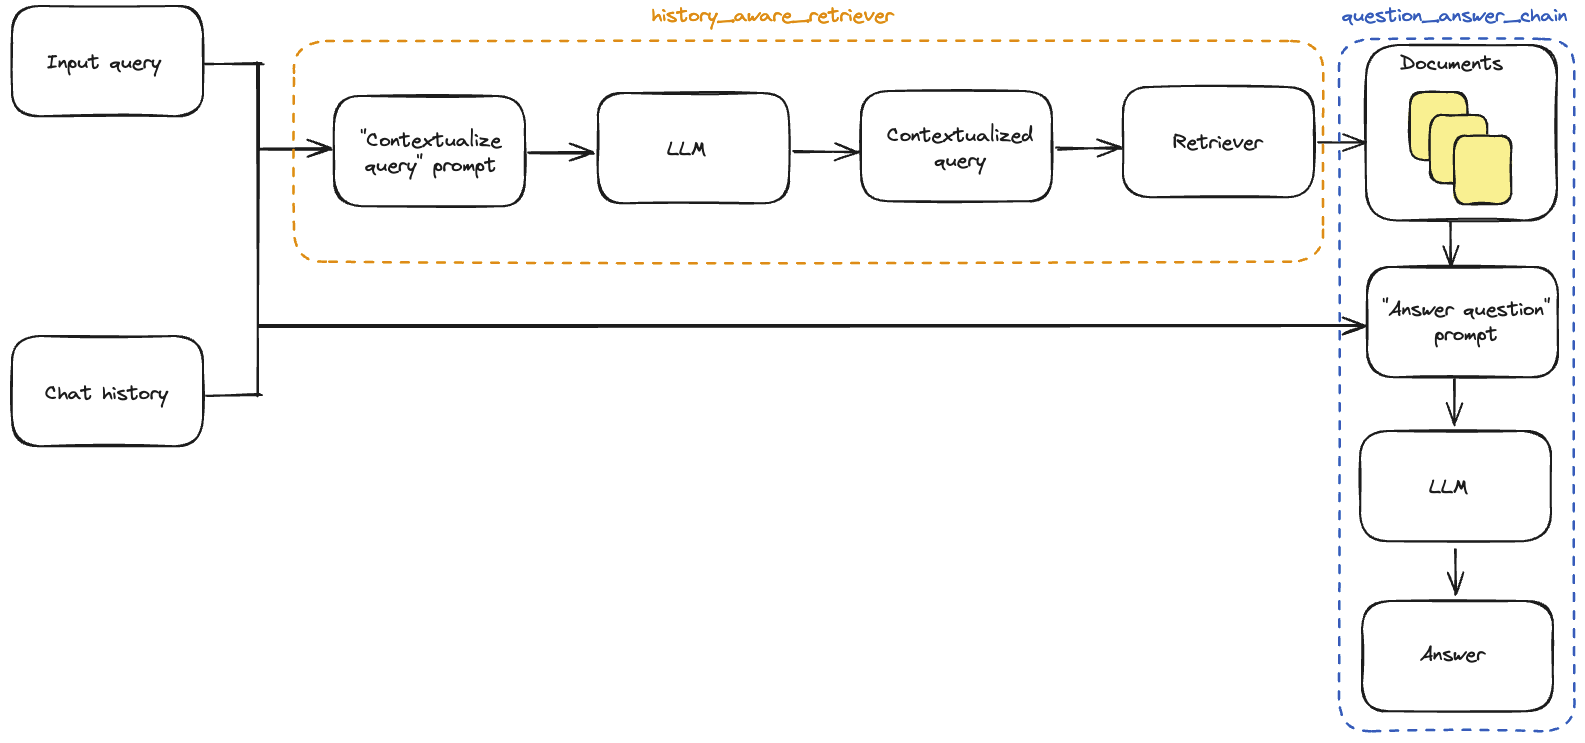

# 完整版代码
为方便起见，我们将所有必要的步骤绑定在一个代码单元中：

In [53]:
import bs4
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import FAISS
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

API_SECRET_KEY = ""
BASE_URL = ""  # 代理 base-url 记得加上 /v1

os.environ["OPENAI_API_KEY"] = API_SECRET_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL
llm = ChatOpenAI()


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

EMBEDDING_DEVICE = "cuda"
embeddings = HuggingFaceEmbeddings( # 使用 Hugging Face 模型进行嵌入
    model_name="../models/m3e-base",
    model_kwargs={"device": EMBEDDING_DEVICE}
)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)
retriever = vectorstore.as_retriever()


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

### 代理（Agents）

代理利用大型语言模型（LLMs）的推理能力在执行过程中做出决策。使用代理可以将检索过程中的一些决策交给模型处理。虽然它们的行为比链条（Chains）更不可预测，但在这种情况下提供了一些优势：

- 代理可以直接生成检索器的输入，而不需要像之前那样显式构建上下文。
- 代理可以针对一个查询执行多个检索步骤，或者在某些情况下（例如用户的泛泛问候）不执行检索步骤。

### 检索工具

代理可以访问“工具”并管理它们的执行。在这种情况下，我们将把我们的检索器转换为一个LangChain工具，让代理来使用：


In [54]:

from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]



### 工具接口

工具是LangChain可运行的对象，并实现了常规接口：


In [55]:
tool.invoke("task decomposition")

'Fig. 2.  Examples of reasoning trajectories for knowledge-intensive tasks (e.g. HotpotQA, FEVER) and decision-making tasks (e.g. AlfWorld Env, WebShop). (Image source: Yao et al. 2023).\nIn both experiments on knowledge-intensive tasks and decision-making tasks, ReAct works better than the Act-only baseline where Thought: … step is removed.\nReflexion (Shinn & Labash 2023) is a framework to equips agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-reflection results.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA co


### Agent 构造函数

现在我们已经定义了工具和LLM，我们可以创建代理。我们将使用LangGraph来构建代理。当前我们使用一个高级接口来构建代理，但LangGraph的好处是，这个高级接口背后是一个低级的、高度可控的API，方便你修改代理逻辑。



In [56]:

from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)




我们现在可以试试看。注意目前它还没有状态管理（我们还需要添加内存）。



In [57]:

query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
):
    print(s)
    print("----")


{'agent': {'messages': [AIMessage(content='\n\nTask decomposition is the process of breaking down a complex task or project into smaller, more manageable sub-tasks. This approach allows individuals or teams to focus on one specific aspect of the task at a time, which can help to reduce stress and increase productivity. Task decomposition can also help to identify potential roadblocks or challenges that may arise during the project, allowing for better planning and problem-solving. The sub-tasks created during task decomposition should be easily achievable and contribute to the overall success of the larger task or project.', response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 70, 'total_tokens': 174}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-67506d48-793e-4b4f-9641-65877abe1561-0', usage_metadata={'input_tokens': 70, 'output_tokens': 104, 'total_tokens': 174})]}}
----


LangGraph 内置了持久性，因此我们不需要使用 ChatMessageHistory！相反，我们可以直接将检查点传递给我们的 LangGraph 代理

In [58]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

agent_executor = create_react_agent(llm, tools, checkpointer=memory)

这就是我们构建对话式 RAG 代理所需的全部内容。

让我们观察它的行为。请注意，如果我们输入不需要检索步骤的查询，则代理不会执行：

In [59]:
config = {"configurable": {"thread_id": "abc123"}}

for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Hi! I'm bob")]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 69, 'total_tokens': 80}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f4c90e1e-ea71-45eb-8251-cc8b24ebdc60-0', usage_metadata={'input_tokens': 69, 'output_tokens': 11, 'total_tokens': 80})]}}
----


此外，如果我们输入的查询确实需要检索步骤，则代理会生成工具的输入：

In [60]:
query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eQpiwhdmGvsnb56IGjKAFwFP', 'function': {'arguments': '{"query":"Task Decomposition"}', 'name': 'blog_post_retriever', 'parameters': {'type': '', 'properties': None, 'required': None}}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 91, 'total_tokens': 110}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-07587a51-ede4-4f9e-b3f6-33ab5f718571-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition'}, 'id': 'call_eQpiwhdmGvsnb56IGjKAFwFP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'output_tokens': 19, 'total_tokens': 110})]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 2.  Examples of reasoning trajectories for knowledge-intensive tasks (e.g. HotpotQA, FEVER) and decision-making tasks (e.g. AlfWorld Env, WebShop). (Image

上面，代理没有将我们的查询逐字插入到工具中，而是去除了不必要的单词，如“what”和“is”。

同样的原则允许代理在必要时使用对话的上下文：

In [61]:
query = "What according to the blog post are common ways of doing it? redo the search"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tLnUQWCeEzja57Gudjg2yGXI', 'function': {'arguments': '{"query": "Task Decomposition techniques"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 866, 'total_tokens': 884}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1fbed139-4c8f-4318-9f06-b288ff127446-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition techniques'}, 'id': 'call_tLnUQWCeEzja57Gudjg2yGXI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 866, 'output_tokens': 18, 'total_tokens': 884})]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decompos

请注意，代理能够推断出我们查询中的“it”指的是“任务分解”，并因此生成了一个合理的搜索查询——在本例中为“任务分解的常见方法”。

# 完整代码

In [62]:
import bs4
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import create_react_agent

memory = SqliteSaver.from_conn_string(":memory:")
API_SECRET_KEY = ""
BASE_URL = ""  # 代理 base-url 记得加上 /v1

os.environ["OPENAI_API_KEY"] = API_SECRET_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL
llm = ChatOpenAI()


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

EMBEDDING_DEVICE = "cuda"
embeddings = HuggingFaceEmbeddings( # 使用 Hugging Face 模型进行嵌入
    model_name="../models/m3e-base",
    model_kwargs={"device": EMBEDDING_DEVICE}
)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)
retriever = vectorstore.as_retriever()


### Build retriever tool ###
tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]


agent_executor = create_react_agent(llm, tools, checkpointer=memory)